In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import ssl

# To resolve certificate error
ssl._create_default_https_context = ssl._create_unverified_context

device = torch.device('cuda:0' if torch.cuda.is_available()else 'cpu')
print(device)

train_transform = transforms.Compose([
     transforms.Resize(256), 
     transforms.ColorJitter(brightness=0.5),
     transforms.RandomRotation(degrees=45),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
)])

test_transform = transforms.Compose([
     transforms.Resize(256), 
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
)])

batch_size = 5
ap_num, am_num,bird_num,cat_num,deer_num = 0,0,0,0,0

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=train_transform)
ap_indices, am_indices, bird_indices, cat_indices, deer_indices = [],[],[],[],[]
ap_idx, am_idx, bird_idx, cat_idx, deer_idx = trainset.class_to_idx['airplane'], trainset.class_to_idx['automobile'], trainset.class_to_idx['bird'], trainset.class_to_idx['cat'], trainset.class_to_idx['deer']
for i in range(len(trainset)):
  current_class = trainset[i][1]
  if current_class == ap_idx:
    if ap_num<50:
      ap_indices.append(i)
      ap_num+=1
  elif current_class == am_idx:
    if am_num<50:
      am_indices.append(i)
      am_num+=1
  elif current_class == bird_idx:
    if bird_num<50:
      bird_indices.append(i)
      bird_num+=1
  elif current_class == cat_idx:
    if cat_num<50:
      cat_indices.append(i)
      cat_num+=1
  elif current_class == deer_idx:
    if deer_num<50:
      deer_indices.append(i)
      deer_num+=1

print('Number of airplane images:%d'%ap_num)
print('Number of automobile images:%d'%am_num)
print('Number of bird images:%d'%bird_num)
print('Number of cat images:%d'%cat_num)
print('Number of deer images:%d'%deer_num)

new_train = torch.utils.data.Subset(trainset,ap_indices+am_indices+bird_indices+cat_indices+deer_indices)

trainloader = torch.utils.data.DataLoader(new_train, batch_size = batch_size,
                                          shuffle=True, num_workers=2)

ap_num, am_num,bird_num,cat_num,deer_num = 0,0,0,0,0

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=test_transform)
ap_indices, am_indices, bird_indices, cat_indices, deer_indices = [],[],[],[],[]
ap_idx, am_idx, bird_idx, cat_idx, deer_idx = testset.class_to_idx['airplane'], testset.class_to_idx['automobile'], testset.class_to_idx['bird'], testset.class_to_idx['cat'], testset.class_to_idx['deer']
for i in range(len(testset)):
  current_class = testset[i][1]
  if current_class == ap_idx:
    if ap_num<30:
      ap_indices.append(i)
      ap_num+=1
  elif current_class == am_idx:
    if am_num<30:
      am_indices.append(i)
      am_num+=1
  elif current_class == bird_idx:
    if bird_num<30:
      bird_indices.append(i)
      bird_num+=1
  elif current_class == cat_idx:
    if cat_num<30:
      cat_indices.append(i)
      cat_num+=1
  elif current_class == deer_idx:
    if deer_num<30:
      deer_indices.append(i)
      deer_num+=1

print('Number of airplane images:%d'%ap_num)
print('Number of automobile images:%d'%am_num)
print('Number of bird images:%d'%bird_num)
print('Number of cat images:%d'%cat_num)
print('Number of deer images:%d'%deer_num)

new_test = torch.utils.data.Subset(testset,ap_indices+am_indices+bird_indices+cat_indices+deer_indices)

testloader = torch.utils.data.DataLoader(new_test, batch_size = batch_size,
                                         shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer')
           

cuda:0
Files already downloaded and verified
Number of airplane images:50
Number of automobile images:50
Number of bird images:50
Number of cat images:50
Number of deer images:50
Files already downloaded and verified
Number of airplane images:30
Number of automobile images:30
Number of bird images:30
Number of cat images:30
Number of deer images:30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


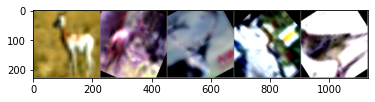

 deer  deer  deer   cat  bird


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' %classes[labels[j]] for j in range(batch_size)))

AlexNet

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchinfo import summary

alexnet = models.alexnet(pretrained=True).to(device)
for param in alexnet.parameters():
    param.requires_grad = False

alexnet.to(device).classifier[4] = nn.Linear(4096, 1024)
alexnet.to(device).classifier[6] = nn.Linear(1024, 5)
alexnet.to(device).eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.to(device).parameters(), lr=0.001, momentum=0.9)

In [5]:
for epoch in range(50):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%50 == 49:
            print('[%d, %5d] loss:%.3f'%(epoch+1,i+1,running_loss/50))
            running_loss =0.0

print('Finished Training')

correct = 0
total = 0

with torch.no_grad():
   for data in testloader:
       images, labels = data
       images = images.to(device)
       labels = labels.to(device)
       outputs_alexnet = alexnet(images)
       _, predicted = torch.max(outputs_alexnet.data, 1)
       total += labels.size(0)
       correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' %(100*correct/total)) 

[1,    50] loss:1.452
[2,    50] loss:0.993
[3,    50] loss:0.866
[4,    50] loss:0.770
[5,    50] loss:0.725
[6,    50] loss:0.772
[7,    50] loss:0.726
[8,    50] loss:0.588
[9,    50] loss:0.652
[10,    50] loss:0.690
[11,    50] loss:0.539
[12,    50] loss:0.496
[13,    50] loss:0.508
[14,    50] loss:0.421
[15,    50] loss:0.460
[16,    50] loss:0.423
[17,    50] loss:0.455
[18,    50] loss:0.518
[19,    50] loss:0.415
[20,    50] loss:0.299
[21,    50] loss:0.382
[22,    50] loss:0.497
[23,    50] loss:0.359
[24,    50] loss:0.524
[25,    50] loss:0.317
[26,    50] loss:0.370
[27,    50] loss:0.325
[28,    50] loss:0.275
[29,    50] loss:0.233
[30,    50] loss:0.359
[31,    50] loss:0.311
[32,    50] loss:0.217
[33,    50] loss:0.373
[34,    50] loss:0.412
[35,    50] loss:0.310
[36,    50] loss:0.280
[37,    50] loss:0.300
[38,    50] loss:0.260
[39,    50] loss:0.234
[40,    50] loss:0.212
[41,    50] loss:0.275
[42,    50] loss:0.189
[43,    50] loss:0.349
[44,    50] loss:0.2

VGG16

In [6]:
vgg16 = models.vgg16(pretrained=True).to(device)
for param in vgg16.parameters():
    param.requires_grad = False

vgg16.to(device).classifier[6] = nn.Linear(4096, 5)
vgg16.to(device).eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.to(device).parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(50):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%50 == 49:
            print('[%d, %5d] loss:%.3f'%(epoch+1,i+1,running_loss/50))
            running_loss =0.0

print('Finished Training')

correct = 0
total = 0

with torch.no_grad():
   for data in testloader:
       images, labels = data
       images = images.to(device)
       labels = labels.to(device)
       outputs_vgg16 = vgg16(images)
       #print(outputs.shape)
       #print(F.softmax(outputs, dim=1)*100.0)
       #print(torch.max(outputs.data))
       #print(labels)
       _, predicted = torch.max(outputs_vgg16.data, 1)
       #print(predicted)
       total += labels.size(0)
       #print(total)
       correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' %(100*correct/total)) 

[1,    50] loss:1.512
[2,    50] loss:1.052
[3,    50] loss:0.919
[4,    50] loss:0.897
[5,    50] loss:0.838
[6,    50] loss:0.755
[7,    50] loss:0.768
[8,    50] loss:0.723
[9,    50] loss:0.750
[10,    50] loss:0.629
[11,    50] loss:0.670
[12,    50] loss:0.668
[13,    50] loss:0.643
[14,    50] loss:0.628
[15,    50] loss:0.624
[16,    50] loss:0.606
[17,    50] loss:0.557
[18,    50] loss:0.545
[19,    50] loss:0.562
[20,    50] loss:0.563
[21,    50] loss:0.571
[22,    50] loss:0.576
[23,    50] loss:0.543
[24,    50] loss:0.540
[25,    50] loss:0.521
[26,    50] loss:0.589
[27,    50] loss:0.548
[28,    50] loss:0.524
[29,    50] loss:0.464
[30,    50] loss:0.476
[31,    50] loss:0.536
[32,    50] loss:0.568
[33,    50] loss:0.527
[34,    50] loss:0.498
[35,    50] loss:0.572
[36,    50] loss:0.609
[37,    50] loss:0.542
[38,    50] loss:0.523
[39,    50] loss:0.453
[40,    50] loss:0.522
[41,    50] loss:0.454
[42,    50] loss:0.519
[43,    50] loss:0.445
[44,    50] loss:0.4

ResNet101

In [9]:

resnet101 = models.resnet101(pretrained=True).to(device)
for param in resnet101.parameters():
    param.requires_grad = False

resnet101.to(device).fc = nn.Linear(2048, 5)
resnet101.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet101.to(device).parameters(), lr=0.001, momentum=0.9)

In [11]:
for epoch in range(50):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet101(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%50 == 49:
            print('[%d, %5d] loss:%.3f'%(epoch+1,i+1,running_loss/50))
            running_loss =0.0

print('Finished Training')

correct = 0
total = 0

with torch.no_grad():
   for data in testloader:
       images, labels = data
       images = images.to(device)
       labels = labels.to(device)
       outputs_resnet = resnet101(images)
       #print(outputs.shape)
       #print(F.softmax(outputs, dim=1)*100.0)
       #print(torch.max(outputs.data))
       #print(labels)
       _, predicted = torch.max(outputs_resnet.data, 1)
       #print(predicted)
       total += labels.size(0)
       #print(total)
       correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' %(100*correct/total)) 


[1,    50] loss:1.431
[2,    50] loss:0.925
[3,    50] loss:0.793
[4,    50] loss:0.697
[5,    50] loss:0.653
[6,    50] loss:0.618
[7,    50] loss:0.604
[8,    50] loss:0.541
[9,    50] loss:0.551
[10,    50] loss:0.514
[11,    50] loss:0.485
[12,    50] loss:0.445
[13,    50] loss:0.493
[14,    50] loss:0.377
[15,    50] loss:0.394
[16,    50] loss:0.372
[17,    50] loss:0.397
[18,    50] loss:0.420
[19,    50] loss:0.376
[20,    50] loss:0.343
[21,    50] loss:0.358
[22,    50] loss:0.334
[23,    50] loss:0.357
[24,    50] loss:0.351
[25,    50] loss:0.330
[26,    50] loss:0.329
[27,    50] loss:0.303
[28,    50] loss:0.343
[29,    50] loss:0.320
[30,    50] loss:0.309
[31,    50] loss:0.352
[32,    50] loss:0.339
[33,    50] loss:0.312
[34,    50] loss:0.328
[35,    50] loss:0.342
[36,    50] loss:0.299
[37,    50] loss:0.327
[38,    50] loss:0.255
[39,    50] loss:0.309
[40,    50] loss:0.342
[41,    50] loss:0.275
[42,    50] loss:0.252
[43,    50] loss:0.298
[44,    50] loss:0.3

GoogLeNet

In [12]:
googlenet = models.googlenet(pretrained=True).to(device)
for param in googlenet.parameters():
    param.requires_grad = False

googlenet.to(device).fc = nn.Linear(1024, 5)
googlenet.to(device).eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet.to(device).parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(50):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%50 == 49:
            print('[%d, %5d] loss:%.3f'%(epoch+1,i+1,running_loss/50))
            running_loss =0.0

print('Finished Training')

correct = 0
total = 0

with torch.no_grad():
   for data in testloader:
       images, labels = data
       images = images.to(device)
       labels = labels.to(device)
       outputs_googlenet = googlenet(images)
       #print(outputs.shape)
       #print(F.softmax(outputs, dim=1)*100.0)
       #print(torch.max(outputs.data))
       #print(labels)
       _, predicted = torch.max(outputs_googlenet.data, 1)
       #print(predicted)
       total += labels.size(0)
       #print(total)
       correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' %(100*correct/total)) 


[1,    50] loss:1.533
[2,    50] loss:1.267
[3,    50] loss:1.129
[4,    50] loss:1.062
[5,    50] loss:0.969
[6,    50] loss:0.901
[7,    50] loss:0.850
[8,    50] loss:0.838
[9,    50] loss:0.822
[10,    50] loss:0.819
[11,    50] loss:0.779
[12,    50] loss:0.776
[13,    50] loss:0.790
[14,    50] loss:0.717
[15,    50] loss:0.764
[16,    50] loss:0.682
[17,    50] loss:0.739
[18,    50] loss:0.724
[19,    50] loss:0.710
[20,    50] loss:0.670
[21,    50] loss:0.719
[22,    50] loss:0.682
[23,    50] loss:0.635
[24,    50] loss:0.658
[25,    50] loss:0.587
[26,    50] loss:0.647
[27,    50] loss:0.615
[28,    50] loss:0.609
[29,    50] loss:0.593
[30,    50] loss:0.630
[31,    50] loss:0.601
[32,    50] loss:0.619
[33,    50] loss:0.560
[34,    50] loss:0.620
[35,    50] loss:0.599
[36,    50] loss:0.568
[37,    50] loss:0.602
[38,    50] loss:0.530
[39,    50] loss:0.558
[40,    50] loss:0.595
[41,    50] loss:0.545
[42,    50] loss:0.516
[43,    50] loss:0.577
[44,    50] loss:0.5

4-in-1 Model

In [18]:
correct = 0
total = 0

with torch.no_grad():
   for data in testloader:
       images, labels = data
       images = images.to(device)
       labels = labels.to(device)
       outputs_alexnet = alexnet(images)
       outputs_vgg16 = vgg16(images)
       outputs_resnet = resnet101(images)
       outputs_googlenet = googlenet(images)
       outputs_4in1 = (outputs_alexnet+outputs_vgg16+outputs_resnet+outputs_googlenet)/4
       #print(outputs.shape)
       #print(F.softmax(outputs, dim=1)*100.0)
       #print(torch.max(outputs.data))
       #print(labels)
       _, predicted = torch.max(outputs_4in1.data, 1)
       #print(predicted)
       total += labels.size(0)
       #print(total)
       correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' %(100*correct/total))

Accuracy: 85 %


In [19]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs_alexnet = alexnet(images)
        outputs_vgg16 = vgg16(images)
        outputs_resnet = resnet101(images)
        outputs_googlenet = googlenet(images)
        outputs_4in1 = (outputs_alexnet+outputs_vgg16+outputs_resnet+outputs_googlenet)/4
        _, predictions = torch.max(outputs_4in1,1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100*float(correct_count)/total_pred[classname]
    print('Accuracy for class {:5s} is : {:.1f} %'.format(classname,accuracy))

Accuracy for class airplane is : 90.0 %
Accuracy for class automobile is : 100.0 %
Accuracy for class bird  is : 83.3 %
Accuracy for class cat   is : 90.0 %
Accuracy for class deer  is : 63.3 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


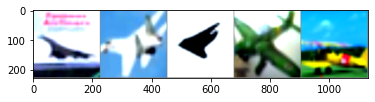

GroundTruth: airplane airplane airplane airplane airplane 


In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',''.join('%5s ' % classes[labels[j]] for j in range(batch_size)))

In [25]:
images = images.to(device)
labels = labels.to(device)
outputs_alexnet = alexnet(images)
outputs_vgg16 = vgg16(images)
outputs_resnet = resnet101(images)
outputs_googlenet = googlenet(images)
outputs_4in1 = (outputs_alexnet+outputs_vgg16+outputs_resnet+outputs_googlenet)/4

In [26]:
_, predicted = torch.max(outputs_4in1,1)

print('Predicted: ', ''.join('%5s' % classes[predicted[j]] for j in range(batch_size)))

Predicted:  airplaneairplaneairplaneairplaneairplane
